:hidden:

# Soon to Be Hidden Code for Graphics in the Lab

This code is hidden for one of three reasons:

- It reveals answers to the code for the projects or labs
- It is only for a graphic and nothing more (when it is included in a pre-lab.)
- Or it is a work-in-progress and should not be revealed to the public until it is refined.

## Project 1, code and graphics

In [3]:
# Defining a Pert Distribution in Python based on: https://pypi.org/project/pertdist/ project. 
# Modified-PERT has four parameters: minimum (a), most likely (b) maximum (c), and lambda, and when
# lambda equals four, it is the same as the pert distribution. 

from scipy import stats as sps
import numpy as np

class pertm_gen(sps.rv_continuous):
    '''modified beta_PERT distribution'''

    def _shape(self, min, mode, max, lmb):
        s_alpha = 1+ lmb*(mode - min)/(max-min)
        s_beta = 1 + lmb*(max - mode)/(max-min)
        return [s_alpha, s_beta]


    def _cdf(self, x, min, mode, max, lmb):
        s_alpha, s_beta = self._shape(min, mode, max, lmb)
        z = (x - min) / (max - min)
        cdf = sps.beta.cdf(z, s_alpha, s_beta)
        return cdf

    def _ppf(self, p, min, mode, max, lmb):
        s_alpha, s_beta = self._shape(min, mode, max, lmb)
        ppf = sps.beta.ppf(p, s_alpha, s_beta)
        ppf = ppf * (max - min) + min
        return ppf

    def _mean(self, min, mode, max, lmb):
        mean = (min + lmb * mode + max) / (2 + lmb)
        return mean

    def _var(self, min, mode, max, lmb):
        mean = self._mean(min, mode, max, lmb)
        var = (mean - min) * (max - mean) / (lmb + 3)
        return var

    def _skew(self, min, mode, max, lmb):
        mean = self._mean(min, mode, max, lmb)
        skew1 = (min + max - 2*mean) / 4
        skew2 = (mean - min) * (max  - mean)
        skew2 = np.sqrt(7 / skew2)
        skew = skew1 * skew2
        return skew

    def _kurt(self, min, mode, max, lmb):
        a1,a2 = self._shape(min, mode, max, lmb)
        kurt1 = a1 + a2 +1
        kurt2 = 2 * (a1 + a2)**2
        kurt3 = a1 * a2 * (a1 + a2 - 6)
        kurt4 = a1 * a2 * (a1 + a2 + 2) * (a1 + a2 + 3)
        kurt5 = 3 * kurt1 * (kurt2 + kurt3)
        kurt = kurt5 / kurt4 -  3                
        return kurt

    def _stats(self, min, mode, max, lmb):
        mean = self._mean(min, mode, max, lmb)
        var = self._var(min, mode, max, lmb)
        skew = self._skew(min, mode, max, lmb)
        kurt = self._kurt(min, mode, max, lmb)
        return mean, var, skew, kurt

pertm = pertm_gen(name="pertm") # Building a "callable" function for the pert class

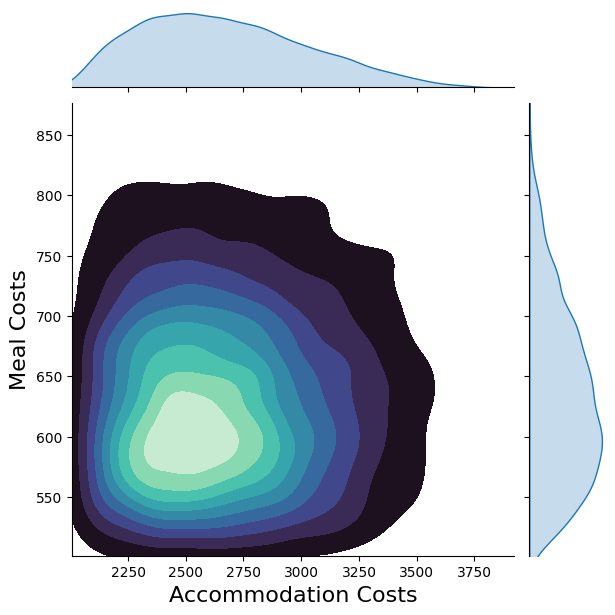

In [4]:
# Gaussian Copula Construction (Based on https://towardsdatascience.com/python-monte-carlo-simulations-copulas-unchained-ff29d051c0a0/)
# and Project 1, which was a mixture between an example from the literature: https://www.youtube.com/watch?v=0RiEquwDjNg and the authors)

# Parameters
# ---------------------------------------
# Plane Fair: Triangular/PERT (5_000, 7_000, 12_000) X
# Accommodation Costs: Triangular/PERT (2_000, 2_500, 4_000) X
# Meals: Triangular/PERT (500, 600, 900) X
# Shopping Expenses: Deterministic(1_000) X
# Holiday Tours: Uniform (1_500, 4_000) X
# Clothing: Triangular/PERT (300, 400, 500) X
# Foreign Exchange: Triangular/PERT (3.75, 4.00, 4.50) X

# Discrete Events
# ----------------------------------------------
# Medical Emergency with two components: (likelihood: bernoulli[0.1] ), (impact: uniform[1_000, 5_000] )
# Theft of Belongings with two components: (likelihood: bernoulli[0.1] ), (impact: triangular[500, 750, 2_000] )

import scipy as sp
import seaborn as sn
import matplotlib.pyplot as mp

N = 10_000 # generating 10,000 random variates

# Matrix from Project 1: Accommodation, Meals, Holiday Tours
c_target = np.array([[1.0, 0.85, 0.85],
                     [0.85, 1.0, 0.85],
                     [0.85, 0.85, 1.0]])

r0 = [0] * c_target.shape[0]                       # Zero-Vector that is the same size of corr matrix.
mv_norm = sps.multivariate_normal(mean=r0, cov=c_target)    # means =  Zero-vector; cov = targeted corr matrix
rand_norm_var = mv_norm.rvs(N)                               # draw N random variates

rand_U = sps.norm.cdf(rand_norm_var)   # normalize random variates into U[0,1]


# Distribution parameters for non-correlated distribution metrics:
pfmin, pfmode, pfmax, pflmb = 5_000.0, 7_000.0, 12_000.0, 4.0 # Plane Fare, P: Triangular/PERT (5_000, 7_000, 12_000) 
cmin, cmode, cmax, clmb = 300, 400, 500, 4.0                  # Clothing, C: Triangular/PERT (300, 400, 500)
exmin, exmode, exmax, exlmb = 3.75, 4.00, 4.50, 4.0           # Foreign Exchange, FE: Triangular/PERT (3.75, 4.00, 4.50)

# Correlated Distribution Parameters:
acmin, acmode, acmax, aclmb = 2_000.0, 2_500.0, 4_000.0, 4.0  # Accommodation Costs, AC: Triangular/PERT (2_000, 2_500, 4_000)
fmin, fmode, fmax, flmb = 500, 600, 900, 4.0                  # Meals, M: Triangular/PERT (500, 600, 900)
ms, ss = 1_500, 4_000                                         # Holiday Tours HT: uniformly distributed [1_500, 4_000]

# Deterministic Distributions
o = 1_000                                                     # shopping, deterministic (1_000)

# Discrete Events and Distributions
ME_Likelihood = 0.1
Theft_Likelihood = 0.1

MEmin, MEmax = 1_000, 5_000.0
Theftmin, Theftode, Theftmax, Theftlmb = 500.0, 750.0, 2_000.0, 4.0

# instantiate the marginal distributions, one for each of the input variables
d_P = pertm(pfmin, pfmode, pfmax, pflmb)   # PF
d_P_C = pertm(cmin, cmode, cmax, clmb)  # Clothing
d_P_FE = pertm(exmin, exmode, exmax, exlmb)  # FE

# Correlated Marginals
d_P_AC = pertm(acmin, acmode, acmax, aclmb) # AC
d_P_M = pertm(fmin, fmode, fmax, flmb) # M
d_P_HT = sps.uniform(ms, ss) # HT

# Discrete Events (This might not work...)
d_ME_Impact = sps.uniform(MEmin, MEmax)
d_Theft_Impact = pertm(Theftmin, Theftode, Theftmax, Theftlmb)

d_ME_Prob = sps.bernoulli(Theft_Likelihood)
d_Theft_Prob = sps.bernoulli(Theft_Likelihood)

# Random Samples
rand_P_AC = d_P_AC.rvs(N)               # Accommodation
rand_N1 = d_P_M.rvs(N)                  # Meals
rand_N2 = d_P_HT.rvs(N)                  # Holiday Tours

# Correlated Random Samples
rand_PF = d_P.rvs(N)                   # PF
rand_C = d_P_C.rvs(N)                  # Clothing
rand_FE = d_P_FE.rvs(N)                # FE 

# Discrete Event Random Samples

rand_ME_Impact = d_ME_Impact.rvs(N)         
rand_Theft_Impact = d_Theft_Impact.rvs(N)  

rand_ME_Prob = d_ME_Prob.rvs(N)                  
rand_Theft_Prob = d_Theft_Prob.rvs(N)                 


def plotcorr(rand1, rand2, name1, name2):
    min1, max1, min2, max2 = rand1.min(), rand1.max(), rand2.min(), rand2.max()
    # h = sn.jointplot(x=rand1, y=rand2, kind='kde', xlim=(min1, max1), ylim=(min2, max2)) # Without Fill
    h = sn.jointplot(x=rand1, y=rand2, kind='kde', xlim=(min1, max1), ylim=(min2, max2),
    # Additional Fill Options:
    fill=True,
    thresh=0.05,      # Extend shading to lower density areas (had to look this up)
    levels=10,
    cmap="mako",     # Colormap (for example:, "blues" "viridis", "mako", "rocket")
    alpha=1
    )
    h.set_axis_labels(name1, name2, fontsize=16)
    return h

s = plotcorr(rand_P_AC, rand_N1, "Accommodation Costs", "Meal Costs")

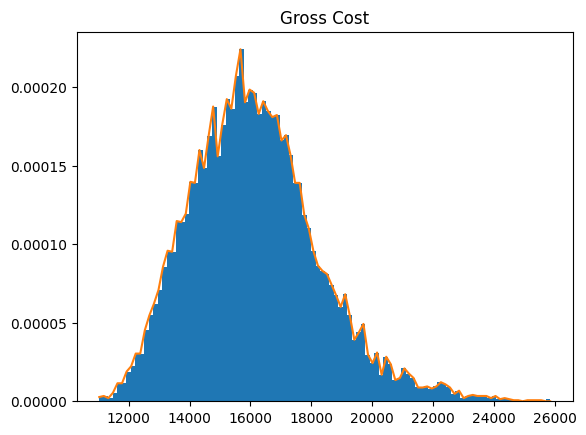

Statistical Information
----------------------
Kurtosis: 0.6804085037889895
Skewness: 0.6081295485509762
Median Cost: 16005.777903620794
Mean Cost: 16160.706979098812


In [ ]:
# Project 1 Simulation 

# Random Samples
rand_P_AC = d_P_AC.rvs(N)               # Accommodation
rand_M = d_P_M.rvs(N)                  # Meals
rand_HT = d_P_HT.rvs(N)                  # Holiday Tours

# Correlated Random Samples
rand_PF = d_P.rvs(N)                   # PF
rand_C = d_P_C.rvs(N)                  # Clothing
rand_FE = d_P_FE.rvs(N)                # FE 

# Discrete Event Random Samples
rand_ME_Impact = d_ME_Impact.rvs(N)         
rand_Theft_Impact = d_Theft_Impact.rvs(N)  

rand_ME_Prob = d_ME_Prob.rvs(N)                  
rand_Theft_Prob = d_Theft_Prob.rvs(N) 

# output variables
GP = rand_P_AC + rand_M + rand_HT + rand_PF + rand_C + rand_FE + (rand_ME_Impact * rand_ME_Prob) + (rand_Theft_Impact * rand_Theft_Prob) + o # simulation output: Total Cost

def plothist(data, name):
    fig = mp.gcf() 
    hist = np.histogram(data, bins=100)
    histdist = sps.rv_histogram(hist)

    X = np.linspace(data.min(), data.max(), 100)
    mp.title(name)
    mp.hist(data, density=True, bins=100)
    mp.plot(X, histdist.pdf(X), label="pdf")
    mp.show()
    return fig


export_plot_project1 = plothist(GP, "Gross Cost")

mean_value = np.mean(GP)
median_value = np.median(GP)
skewness = sps.skew(GP)
kurtosis = sps.kurtosis(GP)

print("Statistical Information")
print("----------------------")
print(f"Kurtosis: {kurtosis}")
print(f"Skewness: {skewness}")
print(f"Median Cost: {median_value}")
print(f"Mean Cost: {mean_value}")

# Lab 1 Implementation using Monaco Documentation (MIT Licensed, so we can use it without restriction)  

Maximum possible standard deviation: 0.500
Number of samples needed to reach an error ≤ ±0.01 at 95.0% confidence if using random vs sobol sampling: 153659 vs 45001
Rounding up to next power of 2: 65536 samples
Running 'integration' Monte Carlo simulation with 65536/65536 cases...
Drawing random samples for 2 input variables via the 'sobol' method... Done
Generating cases... Done


Postprocessing cases: 100%|██████████| 65536/65536 [00:00<00:00, 73032.56 cases/s]


Simulation complete! Runtime: 0:00:02.318936
π ≈ 3.14136, n = 65536, 95.0% error = ±0.00604, stdev=0.411


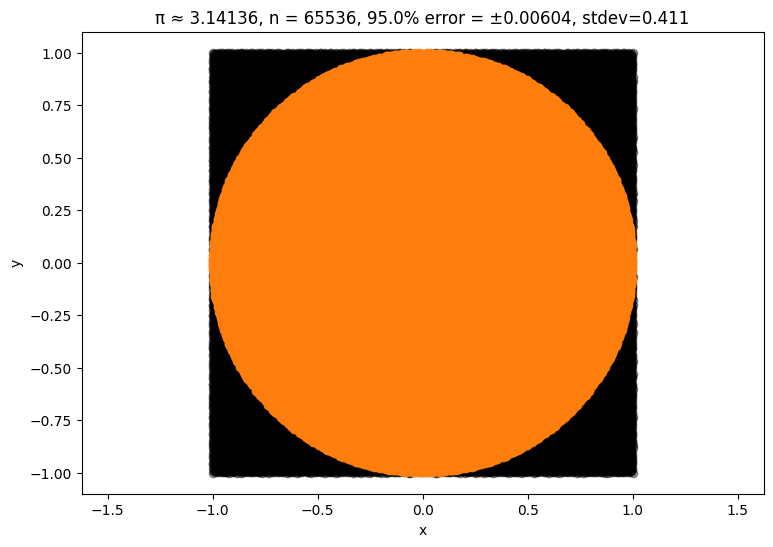

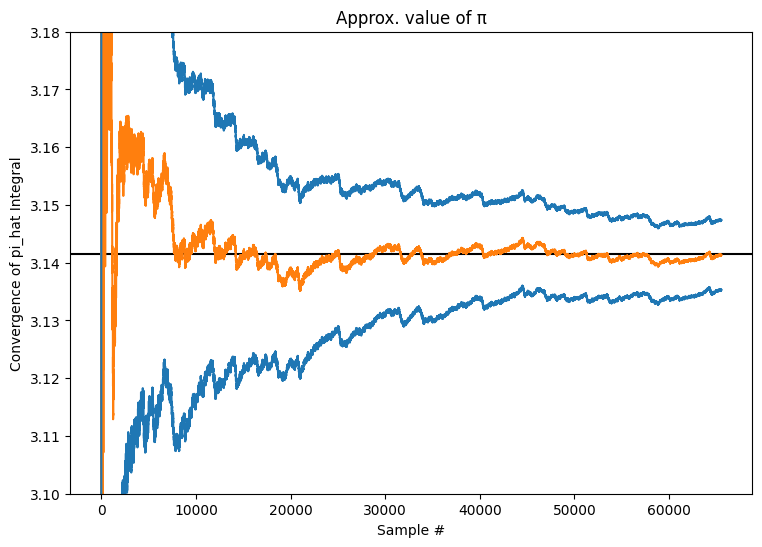

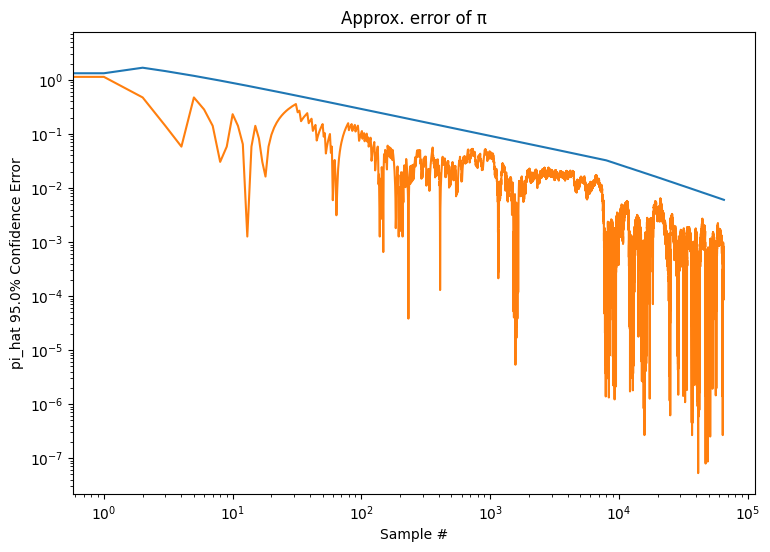

In [13]:
from scipy.stats import uniform
import monaco as mc
import numpy as np

# Define our functions
def integration_example_preprocess(case):
    x = case.invals['x'].val
    y = case.invals['y'].val
    return (x, y)


def integration_example_run(x, y):
    # Note that you can return True/False for simple area integrals (since these
    # vals automatically get valmapped to the nums 1/0), but best practice is to
    # return the value of the function at each sample point.
    isUnderCurve = x**2 + y**2 < 1
    return isUnderCurve


def integration_example_postprocess(case, isUnderCurve):
    case.addOutVal('pi_hat', isUnderCurve)


fcns = {'preprocess' : integration_example_preprocess,
        'run'        : integration_example_run,
        'postprocess': integration_example_postprocess}

# We need to know the limits of integration beforehand, and for integration
# these should always be uniform dists
xrange = [-1, 1]
yrange = [-1, 1]
totalArea = (xrange[1] - xrange[0])*(yrange[1] - yrange[0])
dimension = 2

# Integration best practices:
# File I/O will crush performance, so recommended not to save case data
savecasedata = False
# Use SOBOL over SOBOL_RANDOM for a speedup, since all our dists are uniform
samplemethod = 'sobol'
# Since we want a power of 2, we should not run a 'median' case which would add 1
firstcaseismedian = False

# Maximum Error bound:
# Sobol sampling will give much faster convergence than random.
# A-priori, we do not know the standard deviation, so best practice is to use
# the maximum possible gives the low and high values in your range, and the
# a-posteriori error will be better than this since the actual variance is known.
# You can bootstrap the standard deviation by running a shorter sim and extracting
# stdev from there.
error = 0.01
conf = 0.95
stdev = mc.max_stdev(low=0, high=1)
print(f'Maximum possible standard deviation: {stdev:0.3f}')

nRandom = mc.integration_n_from_err(error=error, dimension=dimension, volume=totalArea,
                                    stdev=stdev, conf=conf, samplemethod='random')
nSobol  = mc.integration_n_from_err(error=error, dimension=dimension, volume=totalArea,
                                    stdev=stdev, conf=conf, samplemethod='sobol')
print(f'Number of samples needed to reach an error ≤ ±{error} at {round(conf*100, 2)}% ' +
      f'confidence if using random vs sobol sampling: {nRandom} vs {nSobol}')

# The sobol methods need to be a power of 2 for best performance and balance
ndraws = mc.next_power_of_2(nSobol)
print(f'Rounding up to next power of 2: {ndraws} samples')

seed = 123639

def integration_example_monte_carlo_sim():

    sim = mc.Sim(name='integration', ndraws=ndraws, fcns=fcns,
                 firstcaseismedian=firstcaseismedian, samplemethod=samplemethod,
                 seed=seed, singlethreaded=True,
                 savecasedata=savecasedata, savesimdata=False,
                 verbose=True, debug=True)

    sim.addInVar(name='x', dist=uniform,
                 distkwargs={'loc': xrange[0], 'scale': (xrange[1] - xrange[0])})  # -1 <= x <= 1
    sim.addInVar(name='y', dist=uniform,
                 distkwargs={'loc': yrange[0], 'scale': (yrange[1] - yrange[0])})  # -1 <= y <= 1

    sim.runSim()

    # Note that (True,False) vals are automatically valmapped to the nums (1,0)
    underCurvePct = sum(sim.outvars['pi_hat'].nums)/ndraws
    err = mc.integration_error(sim.outvars['pi_hat'].nums, dimension=dimension,
                               volume=totalArea, conf=conf,
                               samplemethod=samplemethod, runningerror=False)
    stdev = np.std(sim.outvars['pi_hat'].nums, ddof=1)

    resultsstr = f'π ≈ {underCurvePct*totalArea:0.5f}, n = {ndraws}, ' + \
                 f'{round(conf*100, 2)}% error = ±{err:0.5f}, stdev={stdev:0.3f}'
    print(resultsstr)

    
    import matplotlib.pyplot as plt
    indices_under_curve = [i for i, x in enumerate(sim.outvars['pi_hat'].vals) if x]
    fig, ax = mc.plot(sim.invars['x'], sim.invars['y'], highlight_cases=indices_under_curve)
    ax.axis('equal')
    plt.title(resultsstr)
    fig.set_size_inches(8.8, 6.0)

    fig, ax = mc.plot_integration_convergence(sim.outvars['pi_hat'], dimension=dimension,
                                              volume=totalArea, refval=np.pi, conf=0.95,
                                              title='Approx. value of π',
                                              samplemethod=samplemethod)
    ax.set_ylim((3.10, 3.18))
    fig.set_size_inches(8.8, 6.0)

    fig, ax = mc.plot_integration_error(sim.outvars['pi_hat'], dimension=dimension,
                                        volume=totalArea, refval=np.pi, conf=0.95,
                                        title='Approx. error of π', samplemethod=samplemethod)
    fig.set_size_inches(8.8, 6.0)

    plt.show()
    

    return sim


if __name__ == '__main__':
    sim = integration_example_monte_carlo_sim()

## Lab 1 Implementation Using a For Loop (This is what I expect from Students)

# Lab 2 Implementation using Monaco with Alterations to their example code.

In [40]:
!pip install monaco numba bokeh!=3.0.*,>=2.4.2

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats as stats

def retirement_example_run(yearly_returns, beginning_investments, yearly_spending):
    # yearly_returns: A list of yearly investment returns
    # beginning_investments: The money initially invested
    # yearly_spending: The money withdrawn each year

    nyears = len(yearly_returns)

    starting_balance = np.ones(nyears)*beginning_investments
    ending_balance = np.zeros(nyears)

    for i in range(nyears):
        if i > 0:
            starting_balance[i] = ending_balance[i-1]
        ending_balance[i] = max(starting_balance[i]*(1+yearly_returns[i]) - yearly_spending, 0)

    dates = pd.date_range(start='2020-01-01', periods=nyears, freq='YS')
    df = pd.DataFrame({'Returns'         : yearly_returns,
                       'Spending'        : yearly_spending,
                       'Starting Balance': starting_balance,
                       'Ending Balance'  : ending_balance},
                      index=dates)

    return (df)

def retirement_example_postprocess(case, df):
    # Note that for pandas dataframes, you must explicitly include the index
    case.addOutVal('Date', df.index)
    case.addOutVal('Returns', df['Returns'])
    case.addOutVal('Spending', df['Spending'])
    case.addOutVal('Starting Balance', df['Starting Balance'])
    case.addOutVal('Ending Balance', df['Ending Balance'])

    case.addOutVal('Average Returns', stats.gmean(1 + df['Returns']) - 1)
    case.addOutVal('Final Balance', df['Ending Balance'][-1])
    wentbroke = 'No'
    if df['Ending Balance'][-1] == 0:
        wentbroke = 'Yes'
    case.addOutVal('Broke', wentbroke, valmap={'Yes': 0, 'No': 1})


def retirement_example_preprocess(case):
    nyears = case.constvals['nyears']
    yearly_returns = []
    for i in range(nyears):
        yearly_returns.append(case.invals[f'Year {i} Returns'].val)

    beginning_investments = case.invals['Beginning Balance'].val
    yearly_spending = 0  # setting this equal to zero as the problem never stated retirement funds would be used during the time horizon....

    return (yearly_returns, beginning_investments, yearly_spending)

Dask cluster initiated with 5 workers, 20 threads, 62.42 GiB memory.
Dask dashboard link: http://127.0.0.1:8787/status
Running 'retirement' Monte Carlo simulation with 101/101 cases...
Drawing random samples for 41 input variables via the 'random' method... Done
Generating cases... Done
Preprocessing, running, and postprocessing 303 cases...


/tmp/ipykernel_74114/502799103.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/tmp/ipykernel_74114/502799103.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/tmp/ipykernel_74114/502799103.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/tmp/ipykernel_74114/502799103.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consiste

Simulation complete! Runtime: 0:00:07.567820


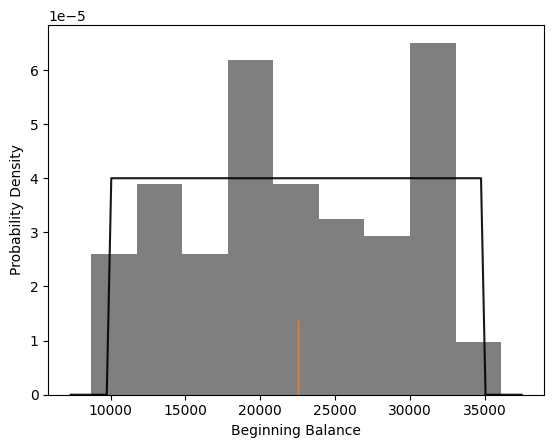

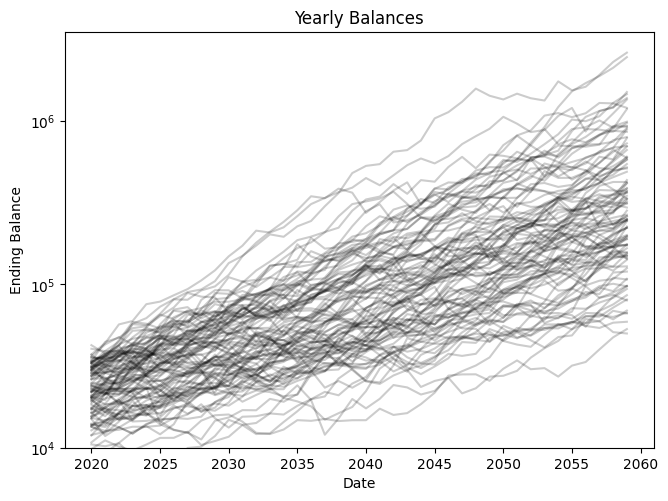

In [19]:
# This is a modification on the example case from github.com/scottshambaugh/monaco/blob/main/examples/early_retirement_investment_portfolio/retirement_example_run.py
# combined with some random ideas from the author. For all intents and purposes, this is Lab 2 with one difference, the Beginning Balance is Stochastic with U(15,000 - 35,000). 

# $p_0 = 25,000$, $r = 0.1 $, $t = 40$, and $s = 10,000$

from scipy.stats import norm, uniform
import monaco as mc
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

fcns = {'preprocess' : retirement_example_preprocess,
        'run'        : retirement_example_run,
        'postprocess': retirement_example_postprocess}

ndraws = 100
seed = 12362397

def retirement_example_monte_carlo_sim():

    sim = mc.Sim(name='retirement', ndraws=ndraws, fcns=fcns,
                 firstcaseismedian=True, samplemethod='random',
                 seed=seed, singlethreaded=False,
                 savecasedata=False,
                 verbose=True, debug=True)

    sp500_mean = 0.10 # Assuming Normality (I have some words about that - nothing is normal)
    sp500_stdev = 0.12 # Assuming an sd of 12 percent.  
    inflation = 0.02 # In the model, we assume inflation would be factored into the return rate...
    nyears = 40 # t = 40

    for i in range(nyears):
        sim.addInVar(name=f'Year {i} Returns', dist=norm,
                     distkwargs={'loc': (sp500_mean - inflation), 'scale': sp500_stdev})

    sim.addInVar(name='Beginning Balance', dist=uniform,
                 distkwargs={'loc': 10_000, 'scale': 25_000}) # Loc: b-a/2, # Scale: average value
    sim.addConstVal(name='nyears', val=nyears)

    sim.runSim()

    wentbrokecases = [i for i, e in enumerate(sim.outvars['Broke'].vals) if e == 'Yes']

    mc.plot(sim.invars['Beginning Balance'], highlight_cases=0)
    fig, ax = mc.plot(sim.outvars['Date'], sim.outvars['Ending Balance'],
                      highlight_cases=wentbrokecases, title='Yearly Balances')
    ax.set_yscale('symlog')
    ax.set_ylim(bottom=1e4)
    fig.set_size_inches(7.6, 5.4)

    return sim


if __name__ == '__main__':
    sim = retirement_example_monte_carlo_sim()

# Prelab 4 and Prelab 8

In [1]:
!pip install aleatory

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [aleatory]


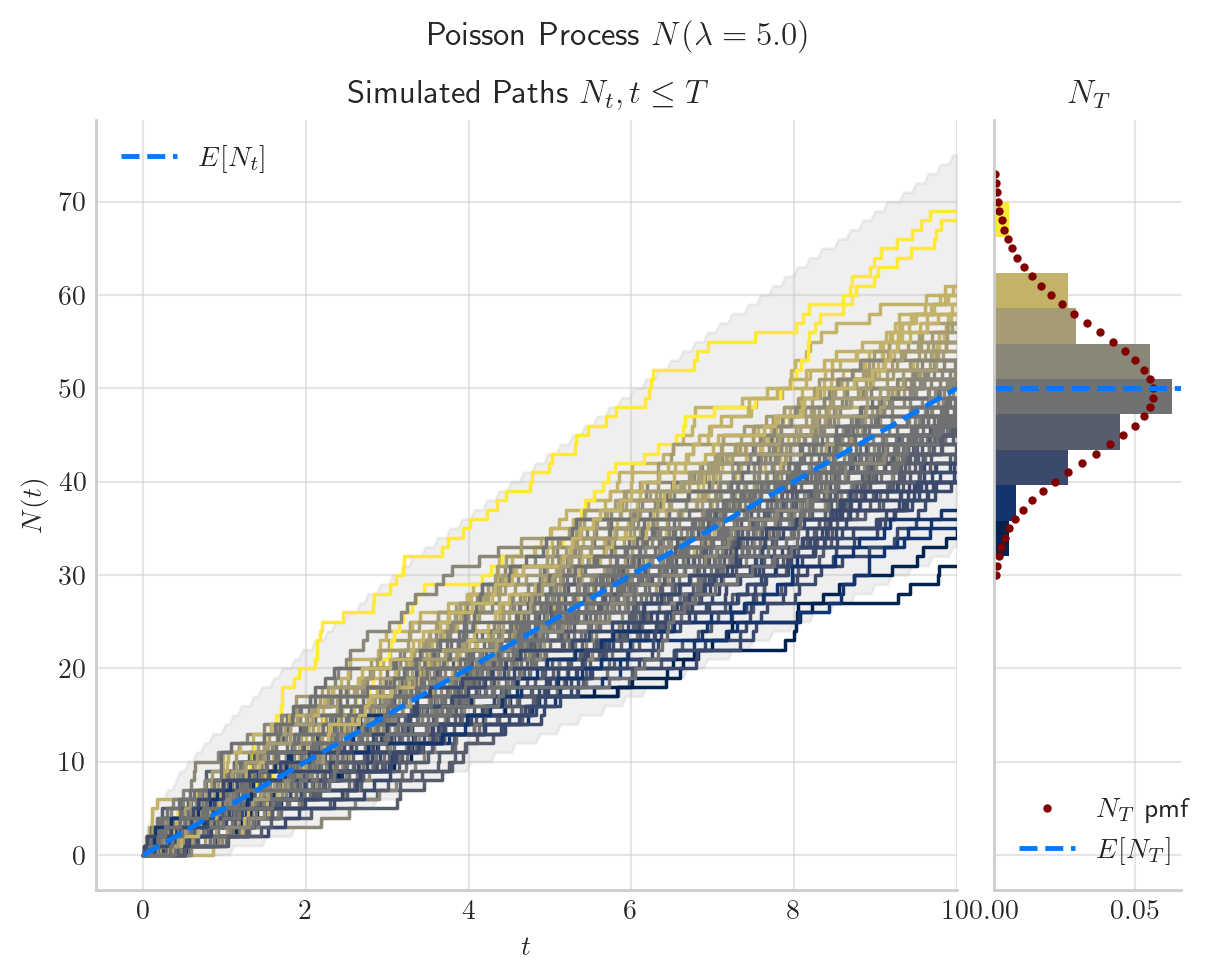

In [31]:
"""
Simulation of a Poisson Process

This graphic shows the different trials for a Poisson Process, and 
how they converge into what we see as a Poisson variate in a simulation.

Based on: 
Dialid Santiago's work in Aleatory which is MIT licensed. 

"""
from aleatory.processes import PoissonProcess

p = PoissonProcess(rate=5.0)

# pp = PoissonProcess()
# paths = pp.simulate(n=100, N=10)

fig_poissonProcess = p.draw(N=100, T=10.0, colormap="cividis", figsize=(7, 5), envelope=True)


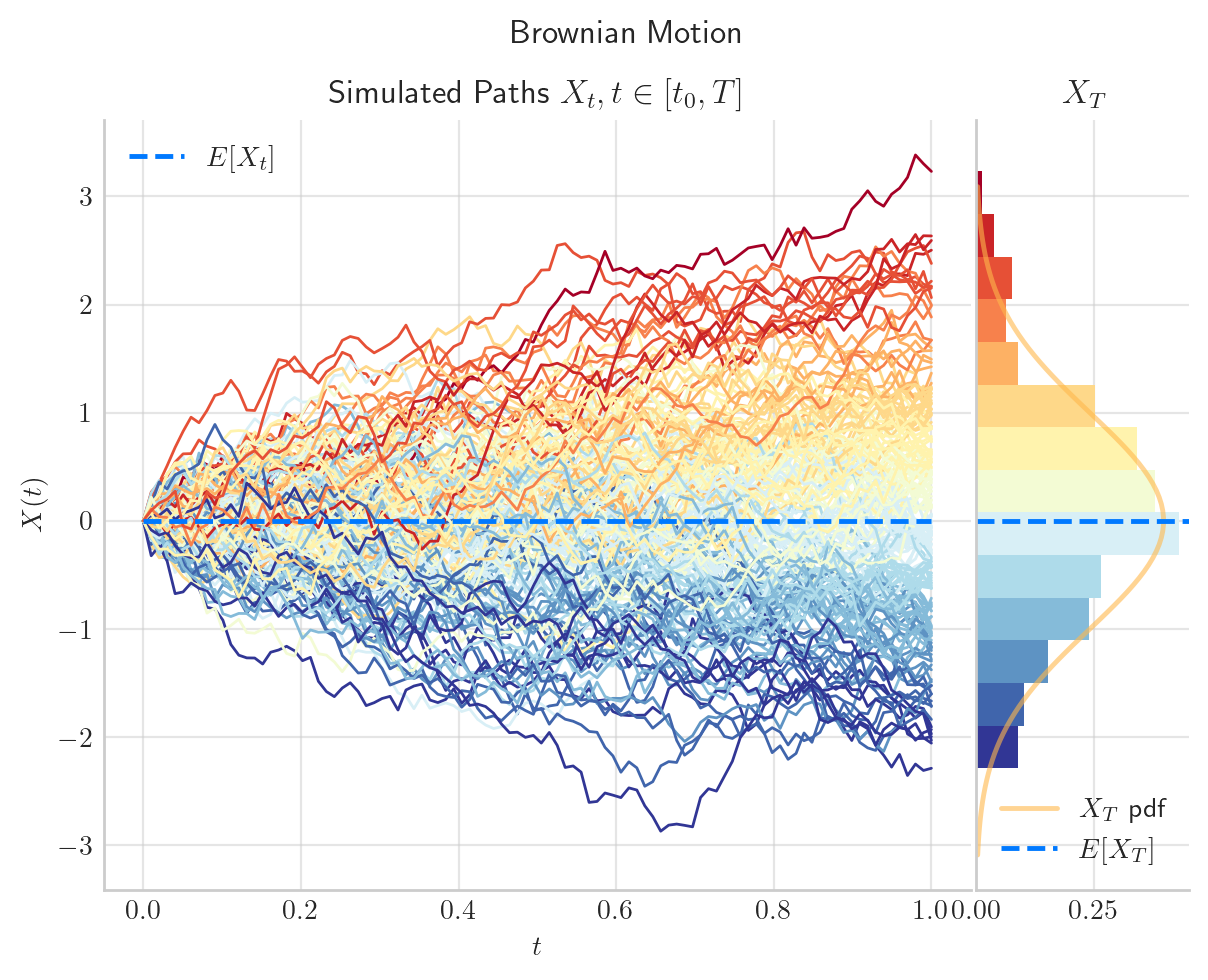

In [35]:
"""
Simulation of Brownian Motion convergence into a Gaussian-Like Distribution

This graphic shows the different trials for Brownian Motion, a common simulation
technique used for stock modelling (although I do wonder how valid that is, as it
assumes normality of the security - which is a big assumption...), and 
how they converge into what we see as a Gaussian variate in a simulation.

Based on: 
Dialid Santiago's work in Aleatory which is MIT licensed. 

"""
from aleatory.processes import BrownianMotion
from aleatory.styles import qp_style

qp_style()  # Use the pastel style from Dialid (I think it might look better than standard pastels...)

bm = BrownianMotion()

# pp = PoissonProcess()
# paths = pp.simulate(n=100, N=10)

fig_BrownianMotion = bm.draw(n=100, N=200, figsize=(7, 5))


In [37]:
i = 0 # External Variable
while i < 5: # While Loop Signature
    print(i) # Operation 1 in Loop
    i += 1 # Operation 2 in Loop

0
1
2
3
4


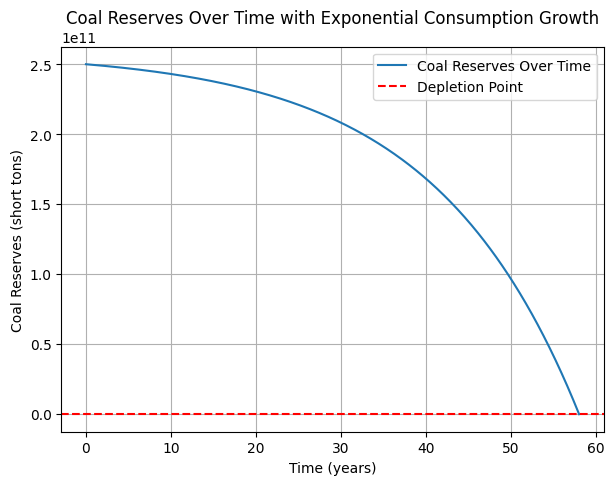

In [20]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

# Given values
I0 = 512.6 * 10**6
C0 = 250 * 10**9 
r = sp.ln(1.06) 

# Define the symbols
t = sp.symbols('t')
T = sp.symbols('T')

# Standard Solution Steps...
equation = sp.Eq(r * T, sp.ln(1 + (r * C0) / I0))
T_solution = sp.solve(equation, T)[0]
# print(f"The time until coal reserves are depleted is approximately {T_solution.evalf()} years.")
C_t = C0 - (I0 / r) * (sp.exp(r * t) - 1)

# Prep for Plot.
C_t_func = sp.lambdify(t, C_t, modules=['numpy'])
time_values = np.linspace(0, float(T_solution), 500)
coal_reserves = C_t_func(time_values)

# Plot the coal reserves over time
coal_fig = plt.figure(figsize=(7, 5))
plt.plot(time_values, coal_reserves, label='Coal Reserves Over Time')
plt.axhline(0, color='red', linestyle='--', label='Depletion Point')
plt.xlabel('Time (years)')
plt.ylabel('Coal Reserves (short tons)')
plt.title('Coal Reserves Over Time with Exponential Consumption Growth')
plt.legend()
plt.grid(True)
plt.show()


## Brusselator and Specific Instance

In [28]:
!pip install py-pde

### ODE Variant

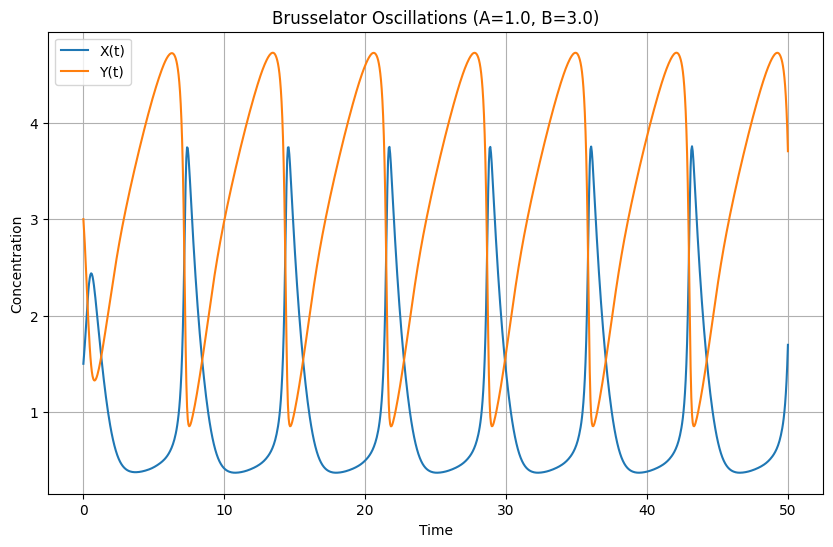

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def brusselator(A, B, X0, Y0, t_span, t_eval):
    """
    Solves and plots the Brusselator ODE system.

    Args:
        A (float): Parameter A in the Brusselator equations.
        B (float): Parameter B in the Brusselator equations.
        X0 (float): Initial concentration of species X.
        Y0 (float): Initial concentration of species Y.
        t_span (tuple): The interval of integration (t_start, t_end).
        t_eval (numpy.ndarray): Times at which to store the computed solution.
    """
    def model(t, Z):
        X, Y = Z
        dXdt = A + X**2 * Y - (B + 1) * X
        dYdt = B * X - X**2 * Y
        return [dXdt, dYdt]

    # Initial conditions
    Z0 = [X0, Y0]

    # Solve the ODE
    sol = solve_ivp(model, t_span, Z0, t_eval=t_eval)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(sol.t, sol.y[0], label='X(t)')
    plt.plot(sol.t, sol.y[1], label='Y(t)')
    plt.xlabel('Time')
    plt.ylabel('Concentration')
    plt.title(f'Brusselator Oscillations (A={A}, B={B})')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Standard Parameter Example---
if __name__ == '__main__':
    # Parameters
    A = 1.0
    B = 3.0

    # Initial conditions
    X0 = 1.5
    Y0 = 3.0

    # Time points for the solution
    t_start = 0
    t_end = 50
    t_points = 1000
    t_span = (t_start, t_end)
    t_eval = np.linspace(t_start, t_end, t_points)

    brusselator(A, B, X0, Y0, t_span, t_eval)

### PDE Variant

In [29]:
from pde import PDE, FieldCollection, PlotTracker, ScalarField, UnitGrid

# define the PDE
a, b = 1, 3
d0, d1 = 1, 0.1
eq = PDE(
    {
        "u": f"{d0} * laplace(u) + {a} - ({b} + 1) * u + u**2 * v",
        "v": f"{d1} * laplace(v) + {b} * u - u**2 * v",
    }
)

# initialize state
grid = UnitGrid([64, 64])
u = ScalarField(grid, a, label="Field $u$")
v = b / a + 0.1 * ScalarField.random_normal(grid, label="Field $v$")
state = FieldCollection([u, v])

# simulate the pde
tracker = PlotTracker(interrupts=1, plot_args={"vmin": 0, "vmax": 5})
sol = eq.solve(state, t_range=20, dt=1e-3, tracker=tracker)

Output()

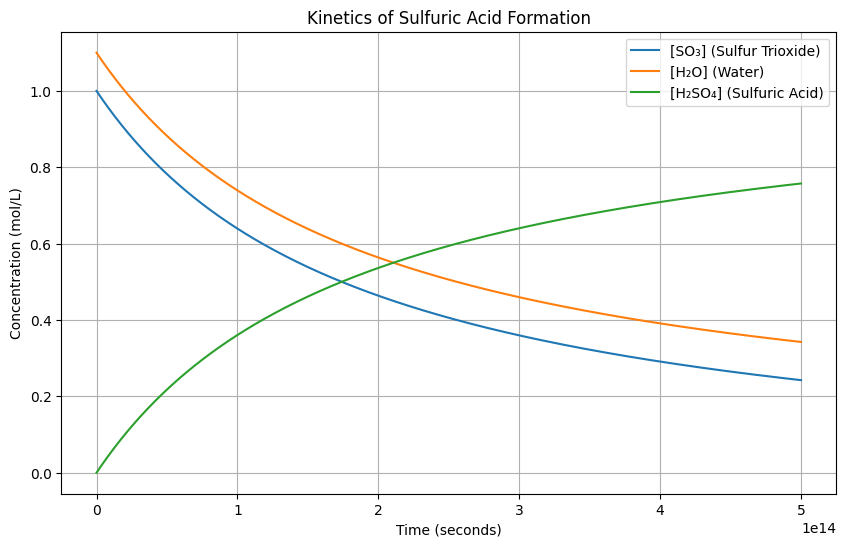

In [31]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# --- Model Definition ---
# This function defines the system of Ordinary Differential Equations (ODEs)
# for the reaction: SO₃ + H₂O -> H₂SO₄ with a slight excess of water.

def sulfuric_acid_kinetics(y, t, k):
    """
    Defines the ODEs for the sulfuric acid formation.
    
    y: array of concentrations [c_SO3, c_H2O, c_H2SO4]
    t: time
    k: the second-order rate constant for the reaction
    """
    c_so3, c_h2o, c_h2so4 = y
    
    # Based on the rate law: Rate = k * [SO₃] * [H₂O]
    reaction_rate = k * c_so3 * c_h2o
    
    # Rate of change for each species (Reactants are consumed, Products are formed)
    d_c_so3_dt = -reaction_rate
    d_c_h2o_dt = -reaction_rate
    d_c_h2so4_dt = +reaction_rate
    
    return [d_c_so3_dt, d_c_h2o_dt, d_c_h2so4_dt]

# --- Simulation Parameters ---
# This is a standard interpretation in chemical kinetics.
k = 5.0e-15  # L/(mol·s)

# Set the initial concentrations ([SO₃], [H₂O], [H₂SO₄]) in mol/L
c_so3_initial = 1.0  # mol/L
c_h2o_initial = 1.1  # mol/L
c_h2so4_initial = 0.0 # Start with no product
y0 = [c_so3_initial, c_h2o_initial, c_h2so4_initial]

# Set the time range for the simulation.
# NOTE: The rate constant is extremely small, so the reaction is very slow, 
# usually you would add heat to this reaction to increase the likelihood of
# collisions (reactions), and therefore reactions. 
# A characteristic time scale is ~1/(k*C_initial) = 1/(5e-15*1) = 2e14 seconds.
t_end = 5e14 # seconds
t = np.linspace(0, t_end, 10000) # Time vector from 0 to t_end

# --- Solve the ODEs ---

# Solve the system of ODEs using odeint
# The 'args' parameter passes the rate constant 'k' to our function.
sol = odeint(sulfuric_acid_kinetics, y0, t, args=(k,))

# --- Plot the Results ---

plt.figure(figsize=(10, 6))
plt.plot(t, sol[:, 0], label='[SO₃] (Sulfur Trioxide)')
plt.plot(t, sol[:, 1], label='[H₂O] (Water)')
plt.plot(t, sol[:, 2], label='[H₂SO₄] (Sulfuric Acid)')

# Formatting the plot
plt.title('Kinetics of Sulfuric Acid Formation')
plt.xlabel('Time (seconds)')
plt.ylabel('Concentration (mol/L)')
plt.legend()
plt.grid(True)
plt.show()

## Heat Equation (Example 3)

In [4]:
!pip install pillow imageio

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags
from scipy.sparse.linalg import spsolve
import ipywidgets as widgets
from IPython.display import display

def solve_heat_equation(L=1, T=200.0, Nx=100, Nt=5000, center_temp=200):
    """
    Solves the 1D heat equation with a central point heat source as the initial condition.
    """
    x = np.linspace(0, L, Nx + 1)
    t = np.linspace(0, T, Nt + 1)
    dx = x[1] - x[0]
    dt = t[1] - t[0]

    # Thermal properties for Copper-Aluminum Bronze (95% Cu, 5% Al)
    k = 83      # Thermal conductivity in W/mK
    rho = 7450  # Density in kg/m^3
    cp = 419    # Specific heat capacity in J/kgK
    alpha = k / (rho * cp)

    F = alpha * dt / dx**2

    u = np.zeros((Nx + 1, Nt + 1))

    # --- MODIFIED INITIAL CONDITION ---
    # The rod starts at 0°C
    u[:, 0] = 0.0
    
    # Heat a small region in the center of the rod to simulate a point source
    center_index = Nx // 2
    # Heat a region approximately 2% of the rod's length
    heat_width = max(1, int(Nx * 0.02)) 
    start_index = center_index - heat_width // 2
    end_index = center_index + heat_width // 2
    u[start_index:end_index + 1, 0] = center_temp
    # --- END MODIFICATION ---

    # Boundary conditions remain 0
    u[0, :] = 0
    u[Nx, :] = 0

    # Create the diagonals for the sparse matrix A
    main_diag = (1 + 2 * F) * np.ones(Nx - 1)
    off_diag = -F * np.ones(Nx - 1)
    A = spdiags([off_diag, main_diag, off_diag], [-1, 0, 1], Nx - 1, Nx - 1).tocsc()

    # Solve the system of equations at each time step
    for n in range(Nt):
        b = u[1:Nx, n]
        u[1:Nx, n + 1] = spsolve(A, b)

    return x, t, u

def plot_heat_distribution(t_val, center_temp):
    """
    Plots the temperature distribution at a specific time.
    """
    L = 1
    T = 200.0   # Maximum time for the simulation
    Nx = 100
    Nt = 5000   # Number of time steps

    x, t, u = solve_heat_equation(L, T, Nx, Nt, center_temp)
    
    # Find the index in the time array corresponding to the slider's value
    t_index = np.argmin(np.abs(t - t_val))

    plt.figure(figsize=(10, 6))
    plt.plot(x, u[:, t_index])
    plt.title(f'Temperature Distribution at t = {t[t_index]:.2f} s')
    plt.xlabel('Position along the rod (m)')
    plt.ylabel('Temperature (°C)')
    plt.ylim(-5, center_temp + 10)
    plt.grid(True)
    plt.show()

# Create interactive widgets
time_slider = widgets.FloatSlider(
    value=0.1,
    min=0.0,
    max=200.0,
    step=0.1,
    description='Time (s):',
    continuous_update=False,
    readout_format='.1f',
)

temp_slider = widgets.FloatSlider(
    value=200,
    min=50,
    max=500,
    step=10,
    description='Center Temp (°C):', # Changed description
    continuous_update=False,
)

# Link the plotting function to the widgets
widgets.interactive(plot_heat_distribution, t_val=time_slider, center_temp=temp_slider)

interactive(children=(FloatSlider(value=0.1, continuous_update=False, description='Time (s):', max=200.0, read…

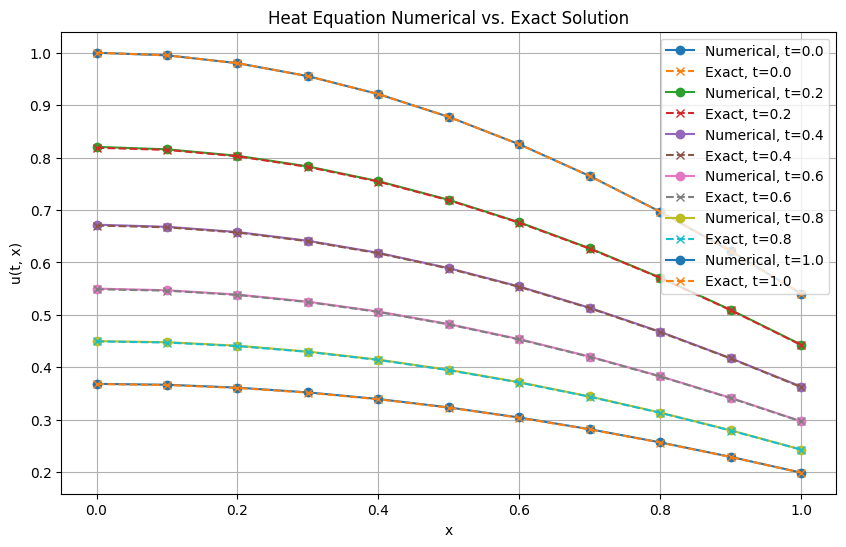

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Method of Manufactured Solutions: exact solution
def u_exact(x, t):
    return np.exp(-t) * np.cos(x)

# Parameters
t_span = [0.0, 1.0]
x_span = [0.0, 1.0]
dx = 0.1
nx = int(x_span[1] / dx) + 1
x = np.linspace(x_span[0], x_span[1], nx)
t_eval = np.arange(t_span[0], t_span[1] + 0.2, 0.2)

# Initial condition for IVP
u0 = u_exact(x, t_span[0])

# PDE function (discretized in space)
def pde_func(t, u):
    dudt = np.zeros_like(u)
    
    # Central difference for 2nd derivative
    for i in range(1, nx - 1):
        dudt[i] = (u[i-1] - 2*u[i] + u[i+1]) / dx**2
        
    # Boundary conditions
    dudt[0] = 0 # Corresponds to u(t, 0) boundary condition.
    dudt[-1] = 0 # Corresponds to u(t, 1) boundary condition

    return dudt

# Create a function to handle the boundary conditions within the solver
def ode_with_bcs(t, u):
    dudt = pde_func(t, u)
    u[0] = np.exp(-t)
    u[-1] = np.exp(-t) * np.cos(1)
    return dudt

# Solve the ODE problem
sol = solve_ivp(ode_with_bcs, t_span, u0, t_eval=t_eval, rtol=1e-6, atol=1e-6)

# Plot results and compare with exact solution
plt.figure(figsize=(10, 6))

for i, t_point in enumerate(sol.t):
    plt.plot(x, sol.y[:, i], 'o-', label=f'Numerical, t={t_point:.1f}')
    plt.plot(x, u_exact(x, t_point), 'x--', label=f'Exact, t={t_point:.1f}')

plt.xlabel('x')
plt.ylabel('u(t, x)')
plt.title('Heat Equation Numerical vs. Exact Solution')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags
from scipy.sparse.linalg import spsolve
import imageio  # For creating the GIF
import os       # To handle files and directories

def solve_heat_equation(L=1, T=200.0, Nx=100, Nt=5000, center_temp=200):
    """
    Solves the 1D heat equation with a central point heat source as the initial condition.
    This function is unchanged from your original code.
    """
    x = np.linspace(0, L, Nx + 1)
    t = np.linspace(0, T, Nt + 1)
    dx = x[1] - x[0]
    dt = t[1] - t[0]

    # Thermal properties for Copper-Aluminum Bronze (95% Cu, 5% Al)
    k = 83      # Thermal conductivity in W/mK
    rho = 7450  # Density in kg/m^3
    cp = 419    # Specific heat capacity in J/kgK
    alpha = k / (rho * cp)

    F = alpha * dt / dx**2
    u = np.zeros((Nx + 1, Nt + 1))

    # --- MODIFIED INITIAL CONDITION ---
    u[:, 0] = 0.0
    center_index = Nx // 2
    heat_width = max(1, int(Nx * 0.02))
    start_index = center_index - heat_width // 2
    end_index = center_index + heat_width // 2
    u[start_index:end_index + 1, 0] = center_temp

    # Boundary conditions remain 0
    u[0, :] = 0
    u[Nx, :] = 0

    # Create the diagonals for the sparse matrix A
    main_diag = (1 + 2 * F) * np.ones(Nx - 1)
    off_diag = -F * np.ones(Nx - 1)
    A = spdiags([off_diag, main_diag, off_diag], [-1, 0, 1], Nx - 1, Nx - 1).tocsc()

    # Solve the system of equations at each time step
    for n in range(Nt):
        b = u[1:Nx, n]
        u[1:Nx, n + 1] = spsolve(A, b)

    return x, t, u

def create_heat_gif(output_filename='heat_equation.gif', n_frames=100, center_temp=200, T=200.0, Nt=5000):
    """
    Solves the heat equation and generates a GIF of the temperature evolution.
    """
    # 1. Solve the equation to get all the data
    print("Solving the heat equation...")
    x, t, u = solve_heat_equation(T=T, Nt=Nt, center_temp=center_temp)
    print("Solution complete.")

    # A temporary directory to store the frames
    frame_dir = 'temp_frames'
    if not os.path.exists(frame_dir):
        os.makedirs(frame_dir)

    filenames = []
    
    # 2. Select 'n_frames' evenly spaced time points to plot
    time_indices = np.linspace(0, Nt, n_frames, dtype=int)

    print(f"Generating {n_frames} frames...")
    for i, t_index in enumerate(time_indices):
        plt.figure(figsize=(10, 6))
        plt.plot(x, u[:, t_index], color='black')
        plt.title(f'Temperature Distribution at t = {t[t_index]:.2f} s')
        plt.xlabel('Position along the rod (m)')
        plt.ylabel('Temperature (°C)')
        # Fix the y-axis for a consistent view across all frames
        plt.ylim(-5, center_temp + 10)
        plt.grid(True)
        
        # 3. Save each plot as an image file
        filename = f"{frame_dir}/frame_{i:03d}.png"
        filenames.append(filename)
        plt.savefig(filename)
        plt.close()

    # 4. Compile the saved frames into a GIF
    print(f"Creating GIF: {output_filename}...")
    with imageio.get_writer(output_filename, mode='I', duration=0.1) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
    print("GIF created successfully.")

    # 5. Clean up the temporary frame files and directory
    for filename in filenames:
        os.remove(filename)
    os.rmdir(frame_dir)

# --- Main execution block ---
if __name__ == '__main__':
    # You can customize the parameters here for the final GIF
    create_heat_gif(
        output_filename='heat_diffusion.gif',
        center_temp=200,   # Initial temperature at the center
        T=200.0,           # Total simulation time in seconds
        n_frames=150       # Number of frames in the final GIF
    )

Solving the heat equation...
Solution complete.
Generating 150 frames...
Creating GIF: heat_diffusion.gif...


/tmp/ipykernel_8513/3857370141.py:91: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


GIF created successfully.


## SIR Model (Prelab 8)

In [1]:
from pde import FieldCollection, PDEBase, PlotTracker, ScalarField, UnitGrid


class SIRPDE(PDEBase):
    """SIR-model with diffusive mobility."""

    def __init__(
        self, beta=0.3, gamma=0.9, diffusivity=0.1, bc="auto_periodic_neumann"
    ):
        super().__init__()
        self.beta = beta  # transmission rate
        self.gamma = gamma  # recovery rate
        self.diffusivity = diffusivity  # spatial mobility
        self.bc = bc  # boundary condition

    def get_state(self, s, i):
        """Generate a suitable initial state."""
        norm = (s + i).data.max()  # maximal density
        if norm > 1:
            s /= norm
            i /= norm
        s.label = "Susceptible"
        i.label = "Infected"

        # create recovered field
        r = ScalarField(s.grid, data=1 - s - i, label="Recovered")
        return FieldCollection([s, i, r])

    def evolution_rate(self, state, t=0):
        s, i, r = state
        diff = self.diffusivity
        ds_dt = diff * s.laplace(self.bc) - self.beta * i * s
        di_dt = diff * i.laplace(self.bc) + self.beta * i * s - self.gamma * i
        dr_dt = diff * r.laplace(self.bc) + self.gamma * i
        return FieldCollection([ds_dt, di_dt, dr_dt])


eq = SIRPDE(beta=2, gamma=0.1)

# initialize state
grid = UnitGrid([32, 32])
s = ScalarField(grid, 1)
i = ScalarField(grid, 0)
i.data[0, 0] = 1
state = eq.get_state(s, i)

# simulate the pde
tracker = PlotTracker(interrupts=10, plot_args={"vmin": 0, "vmax": 1})
sol = eq.solve(state, t_range=50, dt=1e-2, tracker=["progress", tracker])

  0%|          | 0/50.0 [00:00<?, ?it/s]

Output()

In [12]:
from pde import (
    FieldCollection,
    PDEBase,
    ScalarField,
    UnitGrid,
    MemoryStorage 
)
from pde.visualization import movie

class SIRPDE(PDEBase):
    """SIR-model with diffusive mobility."""
    def __init__(self, beta=0.3, gamma=0.9, diffusivity=0.1, bc="auto_periodic_neumann"):
        super().__init__()
        self.beta = beta
        self.gamma = gamma
        self.diffusivity = diffusivity
        self.bc = bc

    def get_state(self, s, i):
        """Generate a suitable initial state."""
        norm = (s + i).data.max()
        if norm > 1:
            s /= norm
            i /= norm
        s.label = "Susceptible"
        i.label = "Infected"
        r = ScalarField(s.grid, data=1 - s - i, label="Recovered")
        return FieldCollection([s, i, r])

    def evolution_rate(self, state, t=0):
        s, i, r = state
        diff = self.diffusivity
        ds_dt = diff * s.laplace(self.bc) - self.beta * i * s
        di_dt = diff * i.laplace(self.bc) + self.beta * i * s - self.gamma * i
        dr_dt = diff * r.laplace(self.bc) + self.gamma * i
        return FieldCollection([ds_dt, di_dt, dr_dt])

# --- Simulation setup ---
eq = SIRPDE(beta=2, gamma=0.1)
grid = UnitGrid([32, 32])
s = ScalarField(grid, 1)
i = ScalarField(grid, 0)
i.data[0, 0] = 1
state = eq.get_state(s, i)

# 1. Run the simulation and store the results in memory
print("Running simulation and storing data...")
storage = MemoryStorage()

# --- CORRECTED LINES ---
# Create a tracker from the storage object, telling it when to record data.
# The `interrupts` argument belongs here.
storage_tracker = storage.tracker(interrupts=0.5)

# Pass the configured tracker object to the solve method.
eq.solve(state, t_range=50, dt=1e-2, tracker=storage_tracker)

print(f"Simulation complete. Data for {len(storage)} frames stored.")

# 2. Create the movie from the stored data
print("Generating movie from stored data...")
movie(storage, filename="sir_from_storage.mp4", plot_args={"vmin": 0, "vmax": 1})
print("Video saved to sir_from_storage.mp4")

Running simulation and storing data...
Simulation complete. Data for 101 frames stored.
Generating movie from stored data...


  0%|          | 0/101 [00:00<?, ?it/s]

Video saved to sir_from_storage.mp4


# Prelab 10

In [13]:
!pip install mesa

In [16]:
import time
import numpy as np
import pandas as pd
import pylab as plt
from mesa import Agent, Model
# from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

class InfectionModel(Model):
    """A model for infection spread."""

    def __init__(self, N=10, width=10, height=10, ptrans=0.5,
                 death_rate=0.02, recovery_days=21,
                 recovery_sd=7):

        self.num_agents = N
        self.recovery_days = recovery_days
        self.recovery_sd = recovery_sd
        self.ptrans = ptrans
        self.death_rate = death_rate
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.running = True
        self.dead_agents = []
        # Create agents
        for i in range(self.num_agents):
            a = MyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
            #make some agents infected at start
            infected = np.random.choice([0,1], p=[0.98,0.02])
            if infected == 1:
                a.state = State.INFECTED
                a.recovery_time = self.get_recovery_time()

        self.datacollector = DataCollector(          
            agent_reporters={"State": "state"})

    def get_recovery_time(self):
        return int(self.random.normalvariate(self.recovery_days,self.recovery_sd))

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()



In [20]:
import enum 

class State(enum.IntEnum):
    SUSCEPTIBLE = 0
    INFECTED = 1
    REMOVED = 2

class MyAgent(Agent):
    """ An agent in an epidemic model."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.age = self.random.normalvariate(20,40)        
        self.state = State.SUSCEPTIBLE  
        self.infection_time = 0

    def move(self):
        """Move the agent"""

        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def status(self):
        """Check infection status"""

        if self.state == State.INFECTED:     
            drate = self.model.death_rate
            alive = np.random.choice([0,1], p=[drate,1-drate])
            if alive == 0:
                self.model.schedule.remove(self)            
            t = self.model.schedule.time-self.infection_time
            if t >= self.recovery_time:          
                self.state = State.REMOVED

    def contact(self):
        """Find close contacts and infect"""

        cellmates = self.model.grid.get_cell_list_contents([self.pos])       
        if len(cellmates) > 1:
            for other in cellmates:
                if self.random.random() > model.ptrans:
                    continue
                if self.state is State.INFECTED and other.state is State.SUSCEPTIBLE:                    
                    other.state = State.INFECTED
                    other.infection_time = self.model.schedule.time
                    other.recovery_time = model.get_recovery_time()

    def step(self):
        self.status()
        self.move()
        self.contact()


In [21]:
model = InfectionModel(pop, 20, 20, ptrans=0.5)
for i in range(steps):
    model.step()
agent_state = model.datacollector.get_agent_vars_dataframe()

NameError: name 'pop' is not defined

# Export Graphics with Labels!

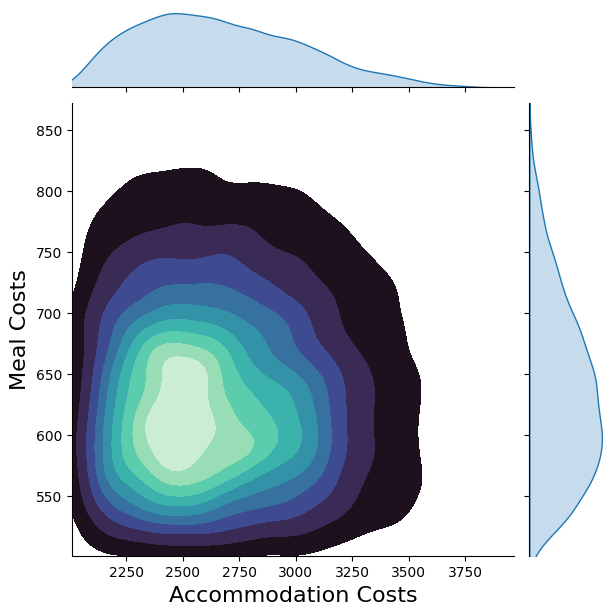

In [31]:
#| label: fig:copula
s.figure

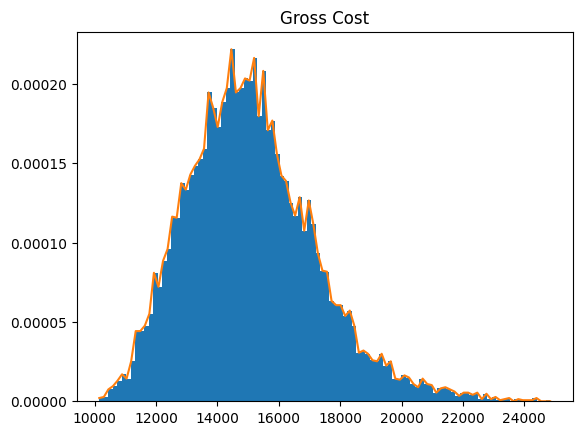

In [49]:
#| label: fig:Gross_Cost_Project1
export_plot_project1

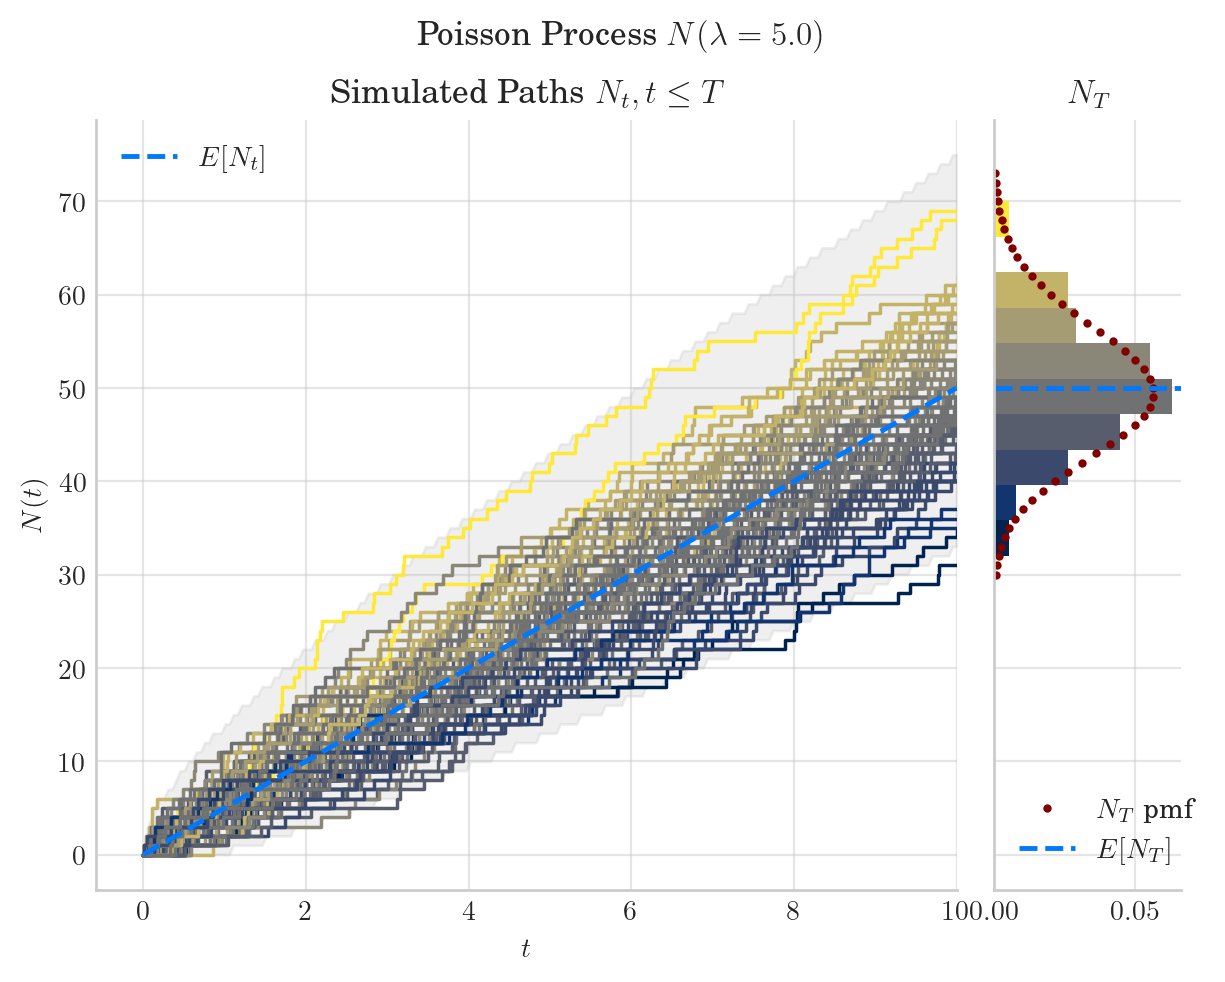

In [34]:
#| label: fig:MCvis_poi
fig_poissonProcess

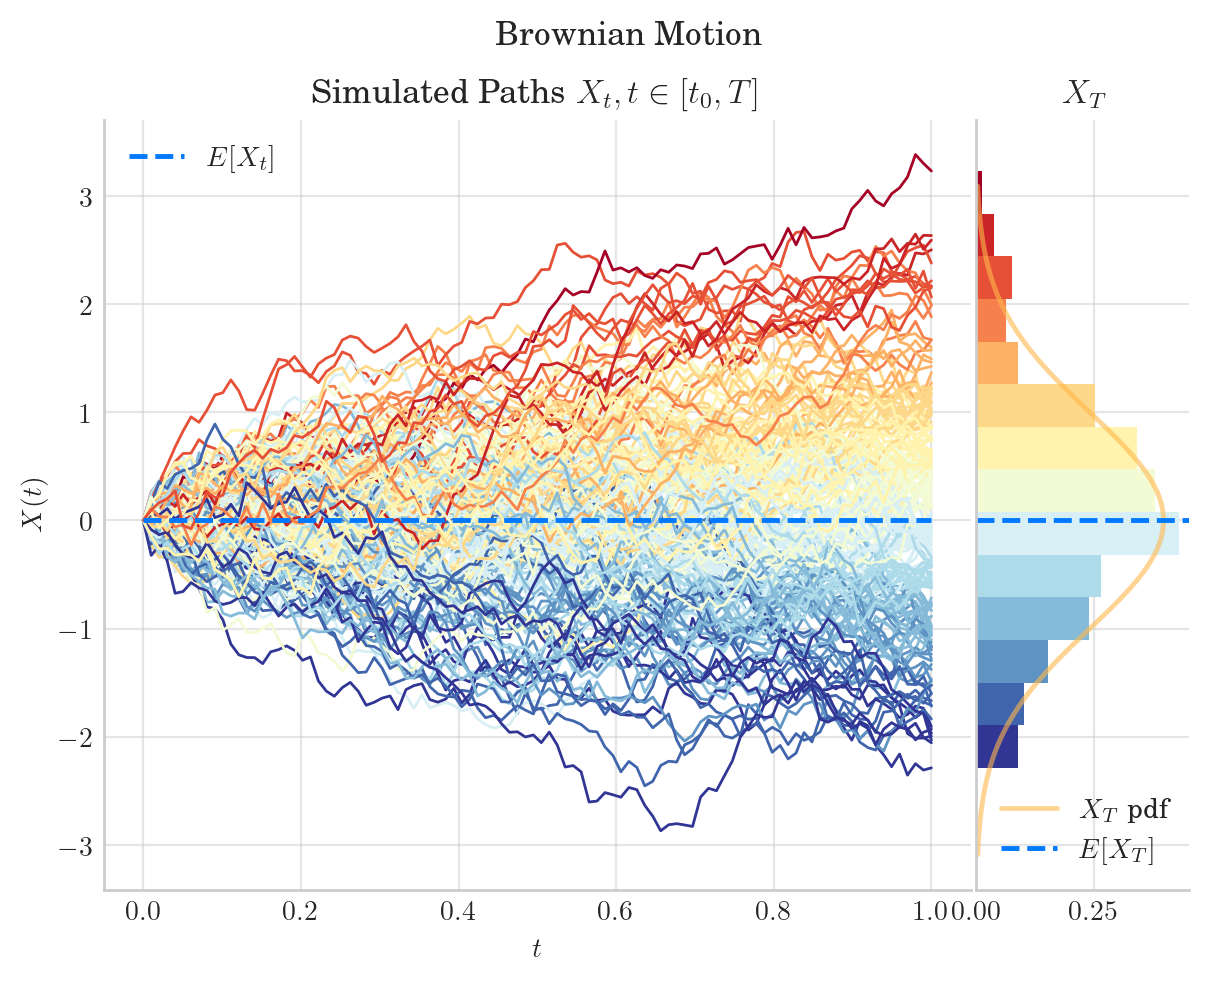

In [36]:
#| label: fig:MCvis_Brownian
fig_BrownianMotion

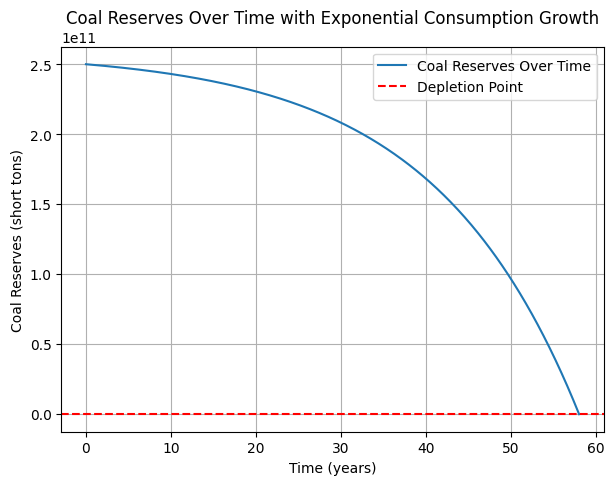

In [21]:
#| label: fig:Coal_Reserves
coal_fig
